# S4E2 - Hyperparameter Optimization

Goal is to classify weight class given physical and lifestyle information

### Explanation of Features

* `FAVC`: Frequent consumption of high caloric food
* `FCVC`: Frequency of consumption of vegetables
* `NCP`: Number of main meals
* `CAEC`: Consumption of food between meals
* `CH20`: Consumption of water daily
* `CALC`: Consumption of alcohol 

The attributes related with the physical condition are: 
* `SCC`: Calories consumption monitoring
* `FAF`: Physical activity frequency
* `TUE`: Time using technology devices
* `MTRANS`: Transportation used

Other Features:
* `Age`
* `Sex`
* `Weight`
* `Height`
* `Smoke`
* `Family_history_with_overweight`



# Installs

In [1]:
!pip install -q scienceplots

# Imports

In [2]:
import numpy as np 
import pandas as pd 
from scipy import stats
pd.set_option('display.max_columns', 50)

import matplotlib.pyplot as plt 
import plotly.express as px
import seaborn as sns
sns.set_style('whitegrid')

import scienceplots
plt.style.use(['science','no-latex'])

import warnings
warnings.filterwarnings("ignore")

# Config

In [3]:
class Config():
    def __init__(self):
        self.seed = 12
        self.folds = 5
        self.add_orig = True
        self.ob_fix = False
        
config = Config()

# Load Data

In [4]:
root_dir = '/kaggle/input/playground-series-s4e2'
train = pd.read_csv(root_dir + '/train.csv') 
test = pd.read_csv(root_dir + '/test.csv') 
ss = pd.read_csv(root_dir + '/sample_submission.csv')

orig = pd.read_csv('/kaggle/input/obesity-or-cvd-risk-classifyregressorcluster/ObesityDataSet.csv')

In [5]:
if config.add_orig:
    train = pd.concat([train,orig])

# Top Level EDA

In [6]:
# print all sets 
print(f'Training Data Shape: {train.shape}') 
display(train.head()) 
print(f'Test Data Shape: {test.shape}') 
display(test.head()) 
print(f'Sample Submission Shape: {ss.shape}') 
display(ss.head())

Training Data Shape: (22869, 18)


,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0.0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1.0,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2.0,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3.0,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4.0,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


Test Data Shape: (13840, 17)


,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,20758,Male,26.899886,1.848294,120.644178,yes,yes,2.938616,3.000000,Sometimes,no,2.825629,no,0.855400,0.000000,Sometimes,Public_Transportation
1,20759,Female,21.000000,1.600000,66.000000,yes,yes,2.000000,1.000000,Sometimes,no,3.000000,no,1.000000,0.000000,Sometimes,Public_Transportation
2,20760,Female,26.000000,1.643355,111.600553,yes,yes,3.000000,3.000000,Sometimes,no,2.621877,no,0.000000,0.250502,Sometimes,Public_Transportation
3,20761,Male,20.979254,1.553127,103.669116,yes,yes,2.000000,2.977909,Sometimes,no,2.786417,no,0.094851,0.000000,Sometimes,Public_Transportation
4,20762,Female,26.000000,1.627396,104.835346,yes,yes,3.000000,3.000000,Sometimes,no,2.653531,no,0.000000,0.741069,Sometimes,Public_Transportation


Sample Submission Shape: (13840, 2)


,id,NObeyesdad
0,20758,Normal_Weight
1,20759,Normal_Weight
2,20760,Normal_Weight
3,20761,Normal_Weight
4,20762,Normal_Weight


In [7]:
def num_of_unique_elements(df):
    summary = pd.DataFrame(df.dtypes, columns=['dtypes']) 
    summary['missing#'] = df.isna().sum() 
    summary['missing%'] = (df.isna().sum())/len(df) 
    summary['uniques'] = df.nunique().values 
    summary['count'] = df.count().values 
    return summary

print(F'Train Data:')
display(num_of_unique_elements(train).style.background_gradient(cmap='Greens'))
print(F'Test Data:')
display(num_of_unique_elements(test).style.background_gradient(cmap='Greens'))


Train Data:


,dtypes,missing#,missing%,uniques,count
id,float64,2111,0.092308,20758,20758
Gender,object,0,0.000000,2,22869
Age,float64,0,0.000000,1739,22869
Height,float64,0,0.000000,1862,22869
Weight,float64,0,0.000000,2014,22869
family_history_with_overweight,object,0,0.000000,2,22869
FAVC,object,0,0.000000,2,22869
FCVC,float64,0,0.000000,975,22869
NCP,float64,0,0.000000,740,22869
CAEC,object,0,0.000000,4,22869


Test Data:


,dtypes,missing#,missing%,uniques,count
id,int64,0,0.000000,13840,13840
Gender,object,0,0.000000,2,13840
Age,float64,0,0.000000,1539,13840
Height,float64,0,0.000000,1739,13840
Weight,float64,0,0.000000,1798,13840
family_history_with_overweight,object,0,0.000000,2,13840
FAVC,object,0,0.000000,2,13840
FCVC,float64,0,0.000000,828,13840
NCP,float64,0,0.000000,649,13840
CAEC,object,0,0.000000,4,13840


In [8]:
obj_cols = [col for col in train.columns if train[col].dtype=='object']
numeric_cols = [col for col in train.columns if train[col].dtype=='float']
bool_cols = [col for col in train.columns if train[col].nunique() == 2]
print(f'There are {len(obj_cols)} categorical columns, {len(bool_cols)} which are boolean, and {len(numeric_cols)} numeric (float) columns')


There are 9 categorical columns, 5 which are boolean, and 9 numeric (float) columns


### Takeaways
* There are 9 categorical columns, 5 which are booelan, and 8 numeric (float) columns
* Not a huge dataset: Train 20.7K files, Test 13.8K files
* No missing data

# Data Cleaning and type conversion
* Convert to lower
* Drop id column
* convert dtypes

In [9]:
def cols_to_lower(df):
    df.columns = df.columns.str.lower()
    return df

def drop_cols(df,drop_cols):
    df = df.drop(columns=drop_cols)
    return df

def convert_dtypes(df):
    for col in df.columns:
        if df[col].nunique() == 2:
            vals = df[col].unique()
            if vals[0] == 'no':
                df[col] = df[col].map({vals[1]:True,vals[0]:False}).astype(bool)
            else:
                df[col] = df[col].map({vals[0]:True,vals[1]:False}).astype(bool)   
                
        elif df[col].dtype == 'object':
            df[col] = df[col].astype('category')
    return df

def rename_cols(df,col_name,new_name):
    df = df.rename(columns={col_name: new_name})
    return df

# perform conversions
train = convert_dtypes(drop_cols(cols_to_lower(train),'id'))
test = convert_dtypes(drop_cols(cols_to_lower(test),'id'))
train = rename_cols(train,'gender','sex_m')
test = rename_cols(test,'gender','sex_m')

train = rename_cols(train,'nobeyesdad','weight_class')

# repopulate the list of column types since changed names
cat_cols = [col for col in test.columns if test[col].dtype=='category']
numeric_cols = [col for col in train.columns if train[col].dtype=='float']
bool_cols = [col for col in train.columns if train[col].nunique() == 2]

train.head()

,sex_m,age,height,weight,family_history_with_overweight,favc,fcvc,ncp,caec,smoke,ch2o,scc,faf,tue,calc,mtrans,weight_class
0,True,24.443011,1.699998,81.669950,True,True,2.000000,2.983297,Sometimes,False,2.763573,False,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,False,18.000000,1.560000,57.000000,True,True,2.000000,3.000000,Frequently,False,2.000000,False,1.000000,1.000000,no,Automobile,Normal_Weight
2,False,18.000000,1.711460,50.165754,True,True,1.880534,1.411685,Sometimes,False,1.910378,False,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,False,20.952737,1.710730,131.274851,True,True,3.000000,3.000000,Sometimes,False,1.674061,False,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,True,31.641081,1.914186,93.798055,True,True,2.679664,1.971472,Sometimes,False,1.979848,False,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22869 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   sex_m                           22869 non-null  bool    
 1   age                             22869 non-null  float64 
 2   height                          22869 non-null  float64 
 3   weight                          22869 non-null  float64 
 4   family_history_with_overweight  22869 non-null  bool    
 5   favc                            22869 non-null  bool    
 6   fcvc                            22869 non-null  float64 
 7   ncp                             22869 non-null  float64 
 8   caec                            22869 non-null  category
 9   smoke                           22869 non-null  bool    
 10  ch2o                            22869 non-null  float64 
 11  scc                             22869 non-null  bool    
 12  faf                     

In [11]:
weight_categories = sorted(list(train.weight_class.value_counts().index))
ordered_weight = weight_categories[0:2] + \
                 [x for x in weight_categories if 'Over' in x] + \
                 [x for x in weight_categories if 'Obes' in x]


# EDA - Univariate Feature Distributions
* Many plots removed for this tuning notebook, see EDA specific notebook for plots

In [12]:
# features = [col for col in test.columns]
# rows = int(np.ceil(len(features)/3)) 

# plt.figure(figsize=(14,4*rows),tight_layout=True) 
# for i,col in enumerate(features): 
#     plt.subplot(rows,3,i+1) 
#     if train[col].dtype == 'float':
#         sns.histplot(train[col],kde=True) 
#         sns.histplot(test[col], kde=True)
#     else:
#         sns.countplot(x=col, data=train,alpha=.5)
#         sns.countplot(x=col, data=test,alpha=.5)
#     plt.xticks(rotation=90)
#     plt.title(col)

## Target Distribution

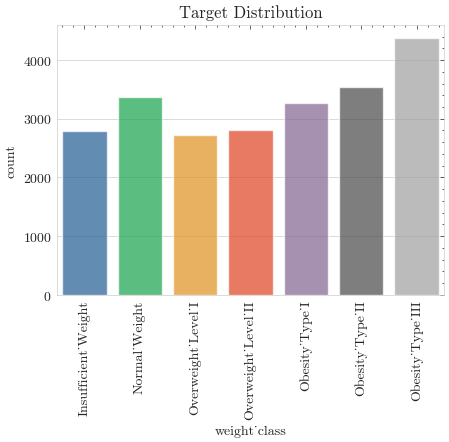

In [13]:
plt.figure(figsize=(5,3.5))
sns.countplot(x='weight_class', data=train, alpha=0.7,order=ordered_weight)
plt.xticks(rotation=90)
plt.title('Target Distribution');

# EDA - Float features vs Target
* TODO: Order is not correct

In [14]:
# feats = numeric_cols
# rows = int(np.ceil(len(feats)/3)) 
# plt.figure(figsize=(12,4*rows),tight_layout=True) 

# for i,col in enumerate(feats): 
#     plt.subplot(rows,3,i+1) 
#     grp = train.groupby('weight_class')[col].mean()
#     sns.barplot(x=grp.index, y = grp.values,alpha=.75,palette='BrBG',order=ordered_weight)
#     plt.xticks(rotation = 90)
#     plt.title(f'Mean {col} grouped by Weight Class')
# plt.show()

## EDA - Boolean Columns vs. Weight Class

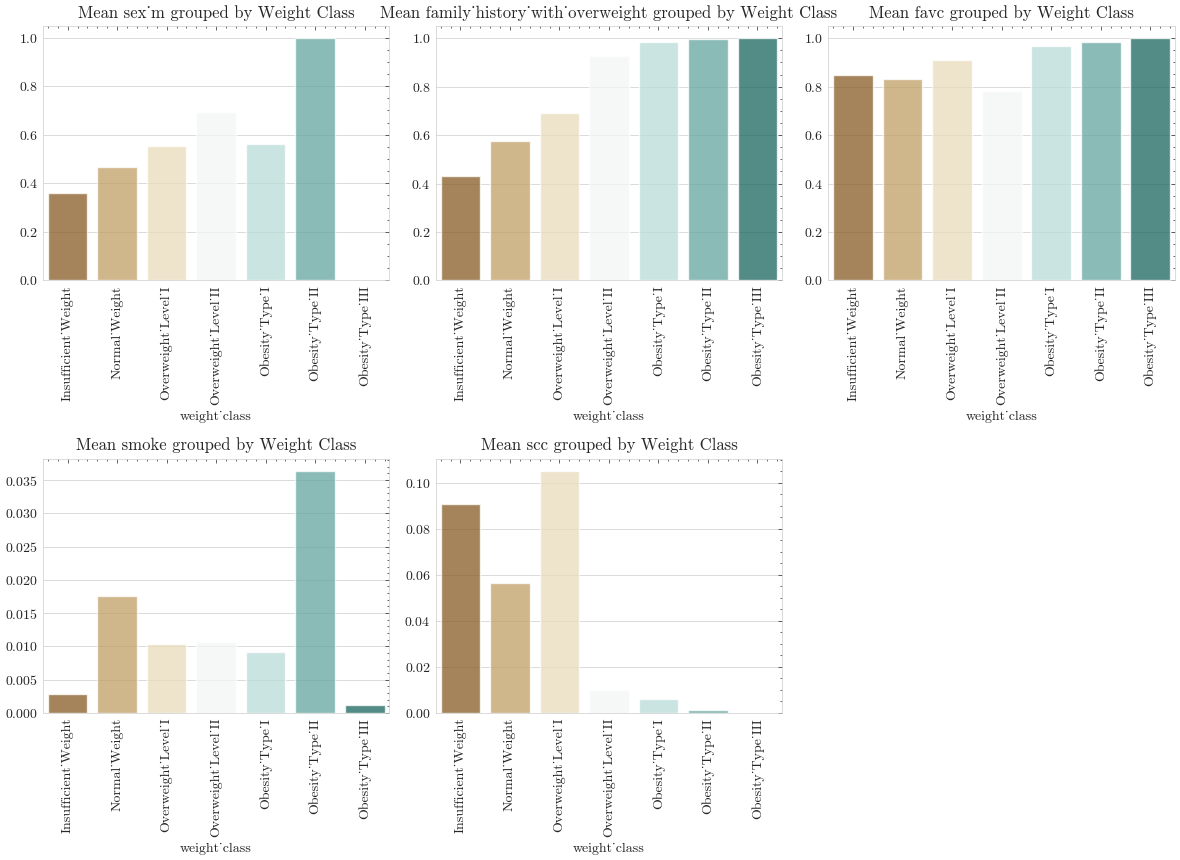

In [15]:
feats = bool_cols
rows = int(np.ceil(len(feats)/3)) 
plt.figure(figsize=(12,4.4*rows),tight_layout=True) 
for i,col in enumerate(feats): 
    plt.subplot(rows,3,i+1) 
    grp = train.groupby('weight_class')[col].mean()
    sns.barplot(x=grp.index, y = grp.values,alpha=.75,palette='BrBG',order=ordered_weight)
    plt.xticks(rotation = 90)
    plt.title(f'Mean {col} grouped by Weight Class')
plt.show()

### Look closer at sex in Obesity Type II and III

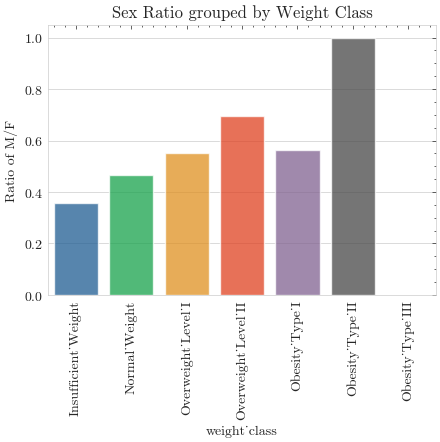

In [16]:
plt.figure(figsize=(5,3.5))
grp = train.groupby('weight_class')['sex_m'].mean()
sns.barplot(x=grp.index, y = grp.values,alpha=.75,order=ordered_weight)
plt.xticks(rotation = 90)
plt.title(f'Sex Ratio grouped by Weight Class')
plt.ylabel('Ratio of M/F')
plt.show()

* Something is up with Obesity type II having ~100% males and Obesity type III having ~100% females
    * 3240/3248 of obesity type II are men
    * 5/4046 of obesity type III are men


* Look at weight distribution in these categories and split that way.
* Or can check with submissions if the same characteristic is in the test data.

### Investigation - Sex in Type II vs Type III Obesity

In [17]:
# trainII = train[train.weight_class=='Obesity_Type_II']
# trainIII = train[train.weight_class=='Obesity_Type_III']

# plt.figure(figsize=(9,4))
# plt.subplot(1,2,1)
# trainII.weight.plot(kind='hist',bins=20,alpha=.5,label='TypeII Obesity')
# plt.legend()
# plt.subplot(1,2,2)
# trainIII.weight.plot(kind='hist',bins=20,alpha=.5,label='TypeIII Obesity',cmap='viridis')
# plt.legend()
# plt.show()

* These are definately bimodal
* I think I will split at around 105 for type II and 120 for type III

In [18]:
# type II is all males, and type III is all females, so for type II change to f if under 106 and III to m if > 118
counta = 0
countb = 0
if config.ob_fix:
    for i in range(len(train)):
        if train.iloc[i].weight_class == 'Obesity_Type_II':
            if train.iloc[i].weight < 106:
                #print(f'i:{i}, II')
                counta +=1
                train.iloc[i, train.columns.get_loc('sex_m')] = False
        elif train.iloc[i].weight_class == 'Obesity_Type_III':
            if train.iloc[i].weight > 118:
                #print(f'i:{i}, III')
                countb +=1
                train.iloc[i, train.columns.get_loc('sex_m')] = True
print(counta, countb)

0 0


## EDA - Categorical Columns

In [19]:
# feats = cat_cols
# rows = int(np.ceil(len(feats)/3)) 
# plt.figure(figsize=(12,4.4*rows),tight_layout=True) 
# for i,col in enumerate(feats): 
#     plt.subplot(rows,3,i+1) 
#     grp = train.groupby(weight_class).col.count()
#     sns.countplot(x=grp.index, y = grp.values,alpha=.75,palette='BrBG',order=ordered_weight)
#     plt.xticks(rotation = 90)
#     plt.title(f'{col} count grouped by weight class')
# plt.show()

## Corellations

In [20]:
# plt.figure(figsize=(16, 6)) 
# mask = np.triu(np.ones_like(train[numeric_cols].corr(),dtype=bool)) 
# heatmap = sns.heatmap(train[numeric_cols].corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG') 
# heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

# Preprocessing

## Scale Float cols
* Not needed for tree based models

In [21]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

std_scaler = StandardScaler()
mm_scaler = MinMaxScaler()
rob_scaler = RobustScaler()

# swap out which scaler you want here (some people scale inside of CV)
# train[numeric_cols] = pd.DataFrame(std_scaler.fit_transform(train[numeric_cols]))
# test[numeric_cols] = pd.DataFrame(std_scaler.transform(test[numeric_cols]))

# update, removed 'columns=features'

## One hot encode categorical columns
* Categorical columns are: 'caec', 'calc', 'mtrans'
* Use OHE, not get_dummies, as we can handle missing values
    * Workaround instead since sklearn ohe is such a pita, add train/test indicator, get_dummies, split, remove indicator.
* Target is also categorical


In [22]:
# define which dataset this is from
train['is_train'] = 1
test['is_train'] = 0

# concatenate dataset and get dummies on all
all_data = pd.concat([train,test])
df = pd.get_dummies(all_data, columns=cat_cols,drop_first=True)

# resplit and remove is_train column from both (and test had the target added with nans)
train = df[df.is_train == 1]
test = df[df.is_train == 0]
train = train.drop('is_train',axis=1)
test = test.drop(['is_train','weight_class'],axis=1)
train.head()

,sex_m,age,height,weight,family_history_with_overweight,favc,fcvc,ncp,smoke,ch2o,scc,faf,tue,weight_class,caec_Frequently,caec_Sometimes,caec_no,calc_Frequently,calc_Sometimes,calc_no,mtrans_Bike,mtrans_Motorbike,mtrans_Public_Transportation,mtrans_Walking
0,True,24.443011,1.699998,81.669950,True,True,2.000000,2.983297,False,2.763573,False,0.000000,0.976473,Overweight_Level_II,False,True,False,False,True,False,False,False,True,False
1,False,18.000000,1.560000,57.000000,True,True,2.000000,3.000000,False,2.000000,False,1.000000,1.000000,Normal_Weight,True,False,False,False,False,True,False,False,False,False
2,False,18.000000,1.711460,50.165754,True,True,1.880534,1.411685,False,1.910378,False,0.866045,1.673584,Insufficient_Weight,False,True,False,False,False,True,False,False,True,False
3,False,20.952737,1.710730,131.274851,True,True,3.000000,3.000000,False,1.674061,False,1.467863,0.780199,Obesity_Type_III,False,True,False,False,True,False,False,False,True,False
4,True,31.641081,1.914186,93.798055,True,True,2.679664,1.971472,False,1.979848,False,1.967973,0.931721,Overweight_Level_II,False,True,False,False,True,False,False,False,True,False


## Encode target with ordinal encoder
* Using ordinal encoder doesn't give correct order, so do it manually

In [23]:
enc = dict(zip(ordered_weight,range(len(ordered_weight))))   
decode = dict(zip(range(len(ordered_weight)),ordered_weight))  
train.weight_class = train.weight_class.map(enc)      

## Add features

In [24]:
train['smoke_drink'] = (train.smoke & train.calc_Frequently)

In [25]:
train.smoke_drink.value_counts()

smoke_drink
False    22853
True        16
Name: count, dtype: int64

## Select Features

In [26]:
y = train.weight_class
features = [col for col in test.columns]
print(features)

['sex_m', 'age', 'height', 'weight', 'family_history_with_overweight', 'favc', 'fcvc', 'ncp', 'smoke', 'ch2o', 'scc', 'faf', 'tue', 'caec_Frequently', 'caec_Sometimes', 'caec_no', 'calc_Frequently', 'calc_Sometimes', 'calc_no', 'mtrans_Bike', 'mtrans_Motorbike', 'mtrans_Public_Transportation', 'mtrans_Walking']


In [27]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13840 entries, 0 to 13839
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   sex_m                           13840 non-null  bool   
 1   age                             13840 non-null  float64
 2   height                          13840 non-null  float64
 3   weight                          13840 non-null  float64
 4   family_history_with_overweight  13840 non-null  bool   
 5   favc                            13840 non-null  bool   
 6   fcvc                            13840 non-null  float64
 7   ncp                             13840 non-null  float64
 8   smoke                           13840 non-null  bool   
 9   ch2o                            13840 non-null  float64
 10  scc                             13840 non-null  bool   
 11  faf                             13840 non-null  float64
 12  tue                             13840

In [28]:
len(y.values)

22869

# CV Split

In [29]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix

In [30]:

def run_cv_and_predict(train, test, features, model, seed, verbose=True):
    
    # initialize arrays 
    fold_scores = []
    oof = np.zeros(train.shape[0])
    preds = np.zeros((test.shape[0],config.folds))

    # setup folding strategy
    skf = StratifiedKFold(n_splits=config.folds,random_state = seed,shuffle=True)

    # start cross validation
    cur_fold = 1
    for trn_idx, val_idx in skf.split(train[features], y):

        # split indicies into train and validation
        x_train = train[features].iloc[trn_idx]
        y_train = y.iloc[trn_idx]
        x_valid = train[features].iloc[val_idx]
        y_valid = y.iloc[val_idx]

        # fit model
        model.fit(x_train,y_train)

        # predict on validation set
        fold_preds = model.predict(x_valid)
        fold_preds = fold_preds.reshape(len(fold_preds)) # sbabwtdt
        oof[val_idx] = fold_preds

        # Compute scores
        fold_score = accuracy_score(y_valid,fold_preds)  # CHOOSE METRIC HERE
        fold_scores.append(fold_score)
        if verbose:
          print(f'Score, fold {cur_fold}: {fold_score}')

        # predict on test set - store all fold preds (take mode later)
        test_preds = model.predict(test[features])
        test_preds = test_preds.reshape(len(test_preds))  # shouldn't have to do this.
        preds[:,cur_fold-1] = test_preds  
        cur_fold +=1
    
    # Print mean fold and oof score 
    oof_score = accuracy_score(y,oof)
    # oof_score = np.sqrt(mean_squared_error(y,oof))
    print(f'Accuracy score: {np.mean(fold_scores):.5f}, Stdev: {np.std(fold_scores):.5f}, OOF score: {oof_score:.5f}')
    # print(f'RMSE score: {np.mean(scores):.5f}, Stdev: {np.std(scores):.5f}, OOF score: {oof_score:.5f}')

    return (preds,fold_scores,oof_score,oof)

# Models
* Logistic Regression
* Random Forest
* Catboost
* XGB
    * XGB tuning with Optuna
* LightGBM


## Logistic Regression

In [31]:
# from sklearn.linear_model import LogisticRegression

# model_lr = LogisticRegression()#random_state = 12,
# #                                    solver = 'liblinear',
# #                                    penalty='l2',
# #                                    multi_class = 'auto', 
# #                                    max_iter=100)


# preds_lr,scores_lr,oof_score_lr,oof_lr = run_cv_and_predict(train,test,features,model_lr,config.seed)

# model_lrg.fit(x_train, y_train)
# pred_lrg = model_lrg.predict(x_valid)
# score_lrg = accuracy_score(y_valid,pred_lrg)
# print(f'LogReg Accuracy Score: {score_lrg:.5f}')


# default logreg Accuracy score: 0.69751, Stdev: 0.00547, OOF score: 0.69751, lb = .69942


## Random Forest

In [32]:
# from sklearn.ensemble import RandomForestClassifier

# model_rf = RandomForestClassifier()

# preds_rf,scores_rf,oof_score_rf,oof_rf = run_cv_and_predict(train,test,features,model_rf,config.seed,verbose=True)

# default random forest: Accuracy score: 0.89247, Stdev: 0.00350, OOF score: 0.89248, lb = .89197
# same hp, OB II and III fix: Accuracy score: 0.89276

## Catboost

In [33]:
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score


# model_cat = CatBoostClassifier(learning_rate = .066,verbose=False)
# preds_cat,scores_cat,oof_score_cat,oof_cat = run_cv_and_predict(train,test,features,model_cat,config.seed,verbose=False)

# default cat: 1000 est, .0913 lr, Accuracy score: 0.90437, Stdev: 0.00259, lb = .90823
# same default, but correct sex in obese II and III (,106 and >118), cv = .90582, std = .00250, lb = .90281 ( much lower?)
# lr .1, .15 both around same, 
# lr to .08: .90535, stdev .00141
# .07: .90572, stdev .00259
# .06: .90481, stdev .00232
# .065: .90601
# .068: .90505
# add orig:  .068: 0.91241, Stdev: 0.00210


# lr range from .05 to .15 in .02 increments
# Accuracy score: 0.91285, Stdev: 0.00191, OOF score: 0.91285
# Accuracy score: 0.91311, Stdev: 0.00175, OOF score: 0.91311
# Accuracy score: 0.91246, Stdev: 0.00165, OOF score: 0.91246
# Accuracy score: 0.91320, Stdev: 0.00212, OOF score: 0.91320
# Accuracy score: 0.91241, Stdev: 0.00210, OOF score: 0.91241
# Accuracy score: 0.91220, Stdev: 0.00165, OOF score: 0.91220
# Accuracy score: 0.91211, Stdev: 0.00267, OOF score: 0.91211
# Accuracy score: 0.91158, Stdev: 0.00170, OOF score: 0.91158
# Accuracy score: 0.91215, Stdev: 0.00247, OOF score: 0.91215
# Accuracy score: 0.91290, Stdev: 0.00228, OOF score: 0.91290
# Accuracy score: 0.91272, Stdev: 0.00197, OOF score: 0.91272
# Accuracy score: 0.91220, Stdev: 0.00296, OOF score: 0.91220
# Accuracy score: 0.91202, Stdev: 0.00264, OOF score: 0.91202
# Accuracy score: 0.91189, Stdev: 0.00234, OOF score: 0.91189
# Accuracy score: 0.91215, Stdev: 0.00263, OOF score: 0.91215

# No idea what happened, just redo later...

# Accuracy score: 0.91237, Stdev: 0.00203, OOF score: 0.91237
# Accuracy score: 0.91145, Stdev: 0.00257, OOF score: 0.91145
# Accuracy score: 0.91180, Stdev: 0.00158, OOF score: 0.91180
# Accuracy score: 0.91176, Stdev: 0.00229, OOF score: 0.91176
# Accuracy score: 0.91215, Stdev: 0.00290, OOF score: 0.91215
# Accuracy score: 0.91215, Stdev: 0.00259, OOF score: 0.91215
# Accuracy score: 0.91180, Stdev: 0.00279, OOF score: 0.91180
# Accuracy score: 0.91180, Stdev: 0.00282, OOF score: 0.91180
# Accuracy score: 0.91220, Stdev: 0.00253, OOF score: 0.91220
# Accuracy score: 0.91303, Stdev: 0.00171, OOF score: 0.91303
# Accuracy score: 0.91145, Stdev: 0.00379, OOF score: 0.91145
# Accuracy score: 0.91241, Stdev: 0.00293, OOF score: 0.91241
# Accuracy score: 0.91211, Stdev: 0.00330, OOF score: 0.91211
# Accuracy score: 0.91154, Stdev: 0.00274, OOF score: 0.91154
# Accuracy score: 0.91202, Stdev: 0.00321, OOF score: 0.91202
# Accuracy score: 0.91101, Stdev: 0.00302, OOF score: 0.91101
# Accuracy score: 0.91171, Stdev: 0.00298, OOF score: 0.91171
# Accuracy score: 0.91224, Stdev: 0.00326, OOF score: 0.91224
# Accuracy score: 0.91115, Stdev: 0.00268, OOF score: 0.91115
# Accuracy score: 0.91158, Stdev: 0.00232, OOF score: 0.91158
# Accuracy score: 0.91080, Stdev: 0.00329, OOF score: 0.91080
# Accuracy score: 0.91163, Stdev: 0.00389, OOF score: 0.91163
# Accuracy score: 0.91167, Stdev: 0.00339, OOF score: 0.91167
# Accuracy score: 0.91154, Stdev: 0.00343, OOF score: 0.91154
# Accuracy score: 0.91272, Stdev: 0.00294, OOF score: 0.91272      
# Accuracy score: 0.91053, Stdev: 0.00377, OOF score: 0.91053
# Accuracy score: 0.91145, Stdev: 0.00343, OOF score: 0.91145
# Accuracy score: 0.91193, Stdev: 0.00233, OOF score: 0.91193
# Accuracy score: 0.91241, Stdev: 0.00360, OOF score: 0.91241
# Accuracy score: 0.91053, Stdev: 0.00277, OOF score: 0.91053

# highest is .91320 with lr = .066, lb = .90968


## XGBoost

In [34]:
from xgboost import XGBClassifier
# model_xgb = XGBClassifier() #max_depth= 8, 
# #                           n_estimators= 125, 
# #                           random_state= 0,  
# #                           learning_rate= 0.03)

# preds_xgb,scores_xgb,oof_score_xgb,oof_xgb = run_cv_and_predict(train,test,features,model_xgb,config.seed,verbose=False)

# default Accuracy score: 0.90922, Stdev: 0.00231, OOF score: 0.90922, lb = .90932

### XGB Optuna Tuning

In [35]:
import optuna

In [36]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(train[features], y, test_size=0.3, random_state=1)

In [37]:

# def objective(trial):
#     """Define the objective function"""

    
# #     params = {
# #         'max_depth': trial.suggest_int('max_depth', 1, 9),
# #         'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
# #         'n_estimators': trial.suggest_int('n_estimators', 50, 500),
# #         'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
# #         'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
# #         'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
# #         'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
# #         'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
# #         'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
# #         'eval_metric': 'mlogloss',
# #         'use_label_encoder': False
# #     }
    
#     params = {
#         'alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0, log=True),
#         'eval_metric': trial.suggest_categorical('eval_metric', ['auc']),
#         'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
#         'lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
#         'learning_rate': trial.suggest_float('learning_rate', 0.001, 1.0, log=True),
#         'max_depth': trial.suggest_int('max_depth', 1, 29),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
#         'n_estimators': trial.suggest_int('n_estimators', 50, 2000),
#         'objective': trial.suggest_categorical('objective', ['binary:logistic']),
#         'random_state': trial.suggest_int('random_state', 0, 0),
#         'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
#         'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
#         'subsample': trial.suggest_float('subsample', 0.01, 1.0, log=True),
#         'use_label_encoder':  trial.suggest_categorical('use_label_encoder', [False]),
#     }

#     # Fit the model
#     optuna_model = XGBClassifier(**params,enable_categorical=True)
#     optuna_model.fit(X_train, y_train)

#     # Make predictions
#     y_pred = optuna_model.predict(X_valid)

#     # Evaluate predictions
#     accuracy = accuracy_score(y_valid, y_pred)
#     return accuracy


In [38]:
# %%time
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=400)

# print('Number of finished trials: {}'.format(len(study.trials)))
# print('Best trial:')
# trial = study.best_trial

# print('  Value: {}'.format(trial.value))
# print('  Params: ')

# for key, value in trial.params.items():
#     print('    {}: {}'.format(key, value))

# # get the best params, create and train a classifier on these params, then predict on test
# params = trial.params


In [39]:
# Number of finished trials: 50
# Best trial:
#   Value: 0.915172715347617
#   Params: 
#     reg_alpha: 0.002390569955744166
#     colsample_bytree: 0.6121792333049014
#     eval_metric: auc
#     gamma: 0.0022110132546763234
#     reg_lambda: 1.0321737715881953e-07
#     learning_rate: 0.026301500576157787
#     max_depth: 17
#     min_child_weight: 8
#     n_estimators: 403
#     objective: binary:logistic
#     random_state: 0
#     subsample: 0.3889066519140065
#     use_label_encoder: False

# Number of finished trials: 200
# Best trial:
#   Value: 0.9176504882670165
#   Params: 
#     reg_alpha: 0.0007498889105685359
#     colsample_bytree: 0.6519563221855783
#     eval_metric: auc
#     gamma: 6.91864445281848e-08
#     reg_lambda: 6.0638995393973435e-05
#     learning_rate: 0.015373343738955594
#     max_depth: 5
#     min_child_weight: 4
#     n_estimators: 1303
#     objective: binary:logistic
#     random_state: 0
#     subsample: 0.3468711195434388
#     use_label_encoder: False

# Number of finished trials: 400
# Best trial:
#   Value: 0.9177962396152164
#   Params: 
#     reg_alpha: 2.818216523458047e-06
#     colsample_bytree: 0.549743279439957
#     eval_metric: auc
#     gamma: 4.106604660161429e-07
#     reg_lambda: 0.020159369096368902
#     learning_rate: 0.024632510159914463
#     max_depth: 9
#     min_child_weight: 3
#     n_estimators: 376
#     objective: binary:logistic
#     random_state: 0
#     subsample: 0.6749704388971823
#     use_label_encoder: False

In [40]:
# run 2
# params = {
#     'reg_alpha': 0.002390569955744166,
#     'colsample_bytree': 0.6121792333049014,
#     'eval_metric': 'auc',
#     'gamma': 0.0022110132546763234,
#     'reg_lambda': 1.0321737715881953e-07,
#     'learning_rate': 0.026301500576157787,
#     'max_depth': 17,
#     'min_child_weight': 8,
#     'n_estimators': 403,
#     'objective': 'binary:logistic',
#     'random_state': 0,
#     'subsample': 0.3889066519140065,
#     'use_label_encoder': False,

# # run 3
# params = {  
#     'reg_alpha': 0.0007498889105685359,
#     'colsample_bytree': 0.6519563221855783,
#     'eval_metric': 'auc',
#     'gamma': 6.91864445281848e-08,
#     'reg_lambda': 6.0638995393973435e-05,
#     'learning_rate': 0.015373343738955594,
#     'max_depth': 5,
#     'min_child_weight': 4,
#     'n_estimators': 1303,
#     'objective': 'binary:logistic',
#     'random_state': 0,
#     'subsample': 0.3468711195434388,
#     'use_label_encoder': False
    
# }

# run 4
params = {  
    'reg_alpha': 2.818216523458047e-06,
    'colsample_bytree': 0.549743279439957,
    'eval_metric': 'auc',
    'gamma': 4.106604660161429e-07,
    'reg_lambda': 0.020159369096368902,
    #'learning_rate': 0.024632510159914463,
    #'max_depth': 9,
    'min_child_weight': 3,
    #'n_estimators': 376,
    'objective':'binary:logistic',
    'random_state': 1,
    'subsample': 0.6749704388971823,
    'use_label_encoder': False
}


opt_model = XGBClassifier(**params)
opt_model.fit(train[features], y)
# y_pred = model.predict(X_valid)
# accuracy = accuracy_score(y_valid, y_pred)
# print("Accuracy after tuning: %.2f%%" % (accuracy * 100.0))

# score = .912xx

preds_opt = opt_model.predict(test[features])

# optuna run 2: Value: 0.915172715347617, lb = .91510!
# optuna run 3: Value: 0.9176504882670165, lb = .91582
# optuna run 4: 0.9177962396152164, lb = 

## Odd behavior in CV, try Other things
* vary random seed, mode of results
* blend of linear ramp of estimators/learning_rate/seed

In [41]:
# cv
#preds_xgb,scores_xgb,oof_score_xgb,oof_xgb = run_cv_and_predict(train,test,features,opt_model,1,verbose=True)
# .91731 for config.seed (12)
# .91622 for config.seed * 2 (24), 
# .91574 for seed of 6
# .91648 for seed of 3
# .91701 for seed of 1

# lets do an average across seeds

all_preds = []
for seed in range(2):
#     preds_xgb,scores_xgb,oof_score_xgb,oof_xgb = run_cv_and_predict(train,test,features,opt_model,seed,verbose=False)
#     preds_xgb = np.mean(preds_xgb,axis=1)
    
    opt_model = XGBClassifier(**params, n_estimators = 376 + seed*100, learning_rate = .024 + (seed*.001))
    opt_model.fit(train[features], y)
    preds_opt = opt_model.predict(test[features])

    all_preds.append(preds_opt)
    
    
# something is wrong with the cv function, as the scores are much lower when I use it (.911 vs .917)

In [42]:
np_preds = np.asarray(all_preds)

In [43]:
np_preds.T

array([[5, 5],
       [2, 2],
       [6, 6],
       ...,
       [0, 0],
       [1, 1],
       [5, 5]])

## LightGBM

In [44]:
# from lightgbm import LGBMClassifier
# model_lgbm = LGBMClassifier()

# preds_lgbm,scores_lgbm,oof_score_lgbm,oof_lgbm = run_cv_and_predict(train,test,features,model_lgbm,config.seed,verbose=False)

#default:Accuracy score: 0.91233, Stdev: 0.00187, OOF score: 0.91233, lb = .91184
# default with sex_m corrections: Accuracy score: 0.91408, Stdev: 0.00185, lb = .89270 (odd that it helps cv but not lb)

## Select Model

In [45]:
model_preds = np_preds.T
preds = []
for l in model_preds:
    preds.append(decode[int(stats.mode(l)[0])])

In [46]:
len(preds)

13840

# Submission

In [47]:
ss.NObeyesdad = preds
ss.head()

,id,NObeyesdad
0,20758,Obesity_Type_II
1,20759,Overweight_Level_I
2,20760,Obesity_Type_III
3,20761,Obesity_Type_I
4,20762,Obesity_Type_III


In [48]:
ss.to_csv('submission.csv',index=False)

<Axes: xlabel='NObeyesdad'>

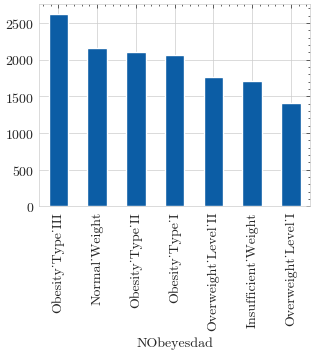

In [49]:
# plot the histogram of data
ss.NObeyesdad.value_counts().plot(kind='bar')